In [120]:
import torch
import torchtext

import pandas as pd
#pd.options.display.max_colwidth = 300
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from math import comb
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
# trained on Wikipedia 2014 + Gigaword 5 vectors
glove = torchtext.vocab.GloVe(name="6B", dim=50, cache='.vector_cache')  

def avg_euclidean_dist(w_lst):
    '''
    Takes in a list of word, computes the sum of euclidean disctance of each
    word-word pair
    '''
    
    eu_dist = torch.tensor(0.0)     # initiates the euclidean distance

    for idx, word_x in enumerate(w_lst):
        if idx != len(w_lst) - 1:       # if not the last word        
            x = glove[word_x]
            for word_y in w_lst[idx+1:]:
                y = glove[word_y]
                eu_dist += torch.norm(y-x)

    C = comb(len(w_lst), 2)
    # divided by the number of possible combinations
    avg_dist = eu_dist/C

    return avg_dist


def avg_cosine_sim(w_lst):
    '''
    Takes in a list of word, computes the sum of euclidean disctance of each
    word-word pair
    '''
    cosine_sim = torch.tensor([0.0])     # initiates cosine similarity value

    for idx, word_x in enumerate(w_lst):
        if idx != len(w_lst) - 1:       # if not the last word        
            x = glove[word_x]
            for word_y in w_lst[idx+1:]:
                y = glove[word_y]
                cosine_sim += torch.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0))
    
    C = comb(len(w_lst), 2)
    # divided by the number of possible combinations
    avg_cosine = cosine_sim/C

    return avg_cosine

In [3]:
subfields = ['atomicphysics', 'biophysics', 'geophysics', 'meteorology', 'oceanography', 'statistics', 'thermodynamics']

Looks at how similar top 25% of stemmed tokens are within a year, disregarding their counts, divided by the number of unique stemmed tokens

In [61]:
def get_df(subfield_name):
    '''
    takes in a string of subfield name, outputs a dataframe
    from 2000-2020
    '''

    file_path = os.getcwd() + '/data/'+subfield_name+'_df.csv'
    df = pd.read_csv(file_path, index_col=0)

    # get the section we want to analyze
    df = df.iloc[-(df.iloc[-1, 0]-2000+1):-(df.iloc[-1, 0]-2020), [0, -2, -1]].reset_index(drop=True) 

    # set name
    df.name = subfield_name
    return df

In [62]:
def minmax_scale(df, col_name):
    '''
    Scales the dataset to [0, 1]
    '''
    df[col_name] = df[col_name].apply(lambda x: (x-df[col_name].min())/(df[col_name].max()-df[col_name].min()))
    
    return df

In [63]:
# get all dfs
atomic_df = get_df(subfields[0])
bio_df = get_df(subfields[1])
geo_df = get_df(subfields[2])
meteo_df = get_df(subfields[3])
ocean_df = get_df(subfields[4])
stats_df = get_df(subfields[5])
thermo_df = get_df(subfields[6])

In [64]:
atomic_df.shape == bio_df.shape == geo_df.shape == meteo_df.shape 
meteo_df.shape == ocean_df.shape == stats_df.shape == thermo_df.shape

True

### Explore the pipeline

In [137]:
atomic_df.head()

,publication_year,NoUS (t25%),t25% of stemmed_tokens
0,2000,228.0,"[[('electron', 97), ('ion', 85), ('energi', 79), ('plasma', 62), ('field', 52), ('state', 47), ('atom', 40), ('magnet', 39), ('structur', 39), ('reson', 37), ('charg', 36), ('laser', 35), ('high', 34), ('surfac', 34), ('wave', 34), ('transit', 34), ('excit', 30), ('level', 29), ('differ', 29), (..."
1,2001,251.0,"[[('electron', 140), ('energi', 121), ('plasma', 100), ('ion', 73), ('state', 72), ('atom', 70), ('field', 54), ('emiss', 48), ('magnet', 46), ('line', 45), ('high', 43), ('densiti', 43), ('excit', 42), ('nuclear', 40), ('model', 39), ('rate', 36), ('laser', 36), ('gas', 33), ('distribut', 33), ..."
2,2002,244.0,"[[('electron', 160), ('energi', 143), ('plasma', 100), ('ion', 76), ('field', 58), ('atom', 55), ('state', 51), ('excit', 48), ('cross', 45), ('effect', 44), ('calcul', 43), ('magnet', 42), ('densiti', 42), ('section', 42), ('quantum', 41), ('structur', 41), ('ionize', 40), ('distribut', 40), ('..."
3,2003,251.0,"[[('energi', 121), ('electron', 99), ('state', 74), ('plasma', 71), ('quantum', 58), ('emiss', 46), ('atom', 45), ('ion', 45), ('excit', 45), ('absorpt', 43), ('wave', 41), ('field', 39), ('reson', 39), ('optic', 38), ('effect', 38), ('distribut', 38), ('potenti', 37), ('calcul', 36), ('gas', 35..."
4,2004,344.0,"[[('energi', 292), ('electron', 242), ('state', 184), ('excit', 135), ('field', 123), ('potenti', 122), ('plasma', 117), ('ion', 114), ('molecular', 109), ('quantum', 106), ('function', 89), ('densiti', 85), ('line', 84), ('vibrat', 79), ('structur', 77), ('calcul', 74), ('magnet', 71), ('reson'..."


In [138]:
atomic_df['tokens_cnt'] = atomic_df["t25% of stemmed_tokens"].apply(eval)

In [139]:
atomic_df['tokens_cnt'] = atomic_df['tokens_cnt'].apply(lambda x: x[0])

In [140]:
atomic_df['tokens'] = atomic_df['tokens_cnt'].apply(lambda x: [i[0] for i in x])

In [141]:
atomic_df.head()

,publication_year,NoUS (t25%),t25% of stemmed_tokens,tokens_cnt,tokens
0,2000,228.0,"[[('electron', 97), ('ion', 85), ('energi', 79), ('plasma', 62), ('field', 52), ('state', 47), ('atom', 40), ('magnet', 39), ('structur', 39), ('reson', 37), ('charg', 36), ('laser', 35), ('high', 34), ('surfac', 34), ('wave', 34), ('transit', 34), ('excit', 30), ('level', 29), ('differ', 29), (...","[(electron, 97), (ion, 85), (energi, 79), (plasma, 62), (field, 52), (state, 47), (atom, 40), (magnet, 39), (structur, 39), (reson, 37), (charg, 36), (laser, 35), (high, 34), (surfac, 34), (wave, 34), (transit, 34), (excit, 30), (level, 29), (differ, 29), (particl, 27), (mass, 27), (interact, 27...","[electron, ion, energi, plasma, field, state, atom, magnet, structur, reson, charg, laser, high, surfac, wave, transit, excit, level, differ, particl, mass, interact, line, nuclear, model, hydrogen, distribut, experiment, rate, cross, densiti, data, configur, ionize, band, emiss, calcul, measur,..."
1,2001,251.0,"[[('electron', 140), ('energi', 121), ('plasma', 100), ('ion', 73), ('state', 72), ('atom', 70), ('field', 54), ('emiss', 48), ('magnet', 46), ('line', 45), ('high', 43), ('densiti', 43), ('excit', 42), ('nuclear', 40), ('model', 39), ('rate', 36), ('laser', 36), ('gas', 33), ('distribut', 33), ...","[(electron, 140), (energi, 121), (plasma, 100), (ion, 73), (state, 72), (atom, 70), (field, 54), (emiss, 48), (magnet, 46), (line, 45), (high, 43), (densiti, 43), (excit, 42), (nuclear, 40), (model, 39), (rate, 36), (laser, 36), (gas, 33), (distribut, 33), (potenti, 33), (radiat, 32), (structur,...","[electron, energi, plasma, ion, state, atom, field, emiss, magnet, line, high, densiti, excit, nuclear, model, rate, laser, gas, distribut, potenti, radiat, structur, reson, molecular, method, wave, observ, temperatur, effect, phase, studi, data, thermal, surfac, transit, optic, quantum, sourc, ..."
2,2002,244.0,"[[('electron', 160), ('energi', 143), ('plasma', 100), ('ion', 76), ('field', 58), ('atom', 55), ('state', 51), ('excit', 48), ('cross', 45), ('effect', 44), ('calcul', 43), ('magnet', 42), ('densiti', 42), ('section', 42), ('quantum', 41), ('structur', 41), ('ionize', 40), ('distribut', 40), ('...","[(electron, 160), (energi, 143), (plasma, 100), (ion, 76), (field, 58), (atom, 55), (state, 51), (excit, 48), (cross, 45), (effect, 44), (calcul, 43), (magnet, 42), (densiti, 42), (section, 42), (quantum, 41), (structur, 41), (ionize, 40), (distribut, 40), (emiss, 40), (wave, 39), (radiat, 39), ...","[electron, energi, plasma, ion, field, atom, state, excit, cross, effect, calcul, magnet, densiti, section, quantum, structur, ionize, distribut, emiss, wave, radiat, reaction, model, surfac, function, puls, laser, rate, time, beam, mass, mode, reson, line, new, level, high, electr, transit, mol..."
3,2003,251.0,"[[('energi', 121), ('electron', 99), ('state', 74), ('plasma', 71), ('quantum', 58), ('emiss', 46), ('atom', 45), ('ion', 45), ('excit', 45), ('absorpt', 43), ('wave', 41), ('field', 39), ('reson', 39), ('optic', 38), ('effect', 38), ('distribut', 38), ('potenti', 37), ('calcul', 36), ('gas', 35...","[(energi, 121), (electron, 99), (state, 74), (plasma, 71), (quantum, 58), (emiss, 46), (atom, 45), (ion, 45), (excit, 45), (absorpt, 43), (wave, 41), (field, 39), (reson, 39), (optic, 38), (effect, 38), (distribut, 38), (potenti, 37), (calcul, 36), (gas, 35), (transit, 35), (structur, 33), (lase...","[energi, electron, state, plasma, quantum, emiss, atom, ion, excit, absorpt, wave, field, reson, optic, effect, distribut, potenti, calcul, gas, transit, structur, laser, densiti, high, line, spectroscopi, depend, temperatur, level, spectra, method, magnet, surfac, interact, ground, ioniz, cross..."
4,2004,344.0,"[[('energi', 292), ('electron', 242), ('state', 184), ('excit', 135), ('field', 123), ('potenti', 122), ('plasma', 117), ('ion', 114), ('molecular', 109), ('quantum', 106), ('function', 89), ('densiti', 85), ('line', 84), ('vibrat', 79), (

In [171]:
atomic_df['avg_euclidean_dist'] = atomic_df['tokens'].apply(avg_euclidean_dist)

In [172]:
atomic_df['avg_cosine_sim'] = atomic_df['tokens'].apply(avg_cosine_sim)

In [173]:
# convert to numbers
atomic_df['avg_euclidean_dist'] = atomic_df['avg_euclidean_dist'].apply(lambda x: x.item())
atomic_df['avg_cosine_sim'] = atomic_df['avg_cosine_sim'].apply(lambda x: x.item())

In [174]:
atomic_copy = atomic_df.copy()

In [177]:
atomic_df = minmax_scale(atomic_df, 'avg_euclidean_dist')

In [178]:
atomic_df = minmax_scale(atomic_df, 'avg_cosine_sim')

In [181]:
atomic_df.head()

,publication_year,NoUS (t25%),t25% of stemmed_tokens,tokens_cnt,tokens,avg_euclidean_dist,avg_cosine_sim
0,2000,228.0,"[[('electron', 97), ('ion', 85), ('energi', 79), ('plasma', 62), ('field', 52), ('state', 47), ('atom', 40), ('magnet', 39), ('structur', 39), ('reson', 37), ('charg', 36), ('laser', 35), ('high', 34), ('surfac', 34), ('wave', 34), ('transit', 34), ('excit', 30), ('level', 29), ('differ', 29), (...","[(electron, 97), (ion, 85), (energi, 79), (plasma, 62), (field, 52), (state, 47), (atom, 40), (magnet, 39), (structur, 39), (reson, 37), (charg, 36), (laser, 35), (high, 34), (surfac, 34), (wave, 34), (transit, 34), (excit, 30), (level, 29), (differ, 29), (particl, 27), (mass, 27), (interact, 27...","[electron, ion, energi, plasma, field, state, atom, magnet, structur, reson, charg, laser, high, surfac, wave, transit, excit, level, differ, particl, mass, interact, line, nuclear, model, hydrogen, distribut, experiment, rate, cross, densiti, data, configur, ionize, band, emiss, calcul, measur,...",0.399405,0.732243
1,2001,251.0,"[[('electron', 140), ('energi', 121), ('plasma', 100), ('ion', 73), ('state', 72), ('atom', 70), ('field', 54), ('emiss', 48), ('magnet', 46), ('line', 45), ('high', 43), ('densiti', 43), ('excit', 42), ('nuclear', 40), ('model', 39), ('rate', 36), ('laser', 36), ('gas', 33), ('distribut', 33), ...","[(electron, 140), (energi, 121), (plasma, 100), (ion, 73), (state, 72), (atom, 70), (field, 54), (emiss, 48), (magnet, 46), (line, 45), (high, 43), (densiti, 43), (excit, 42), (nuclear, 40), (model, 39), (rate, 36), (laser, 36), (gas, 33), (distribut, 33), (potenti, 33), (radiat, 32), (structur,...","[electron, energi, plasma, ion, state, atom, field, emiss, magnet, line, high, densiti, excit, nuclear, model, rate, laser, gas, distribut, potenti, radiat, structur, reson, molecular, method, wave, observ, temperatur, effect, phase, studi, data, thermal, surfac, transit, optic, quantum, sourc, ...",0.903876,1.000000
2,2002,244.0,"[[('electron', 160), ('energi', 143), ('plasma', 100), ('ion', 76), ('field', 58), ('atom', 55), ('state', 51), ('excit', 48), ('cross', 45), ('effect', 44), ('calcul', 43), ('magnet', 42), ('densiti', 42), ('section', 42), ('quantum', 41), ('structur', 41), ('ionize', 40), ('distribut', 40), ('...","[(electron, 160), (energi, 143), (plasma, 100), (ion, 76), (field, 58), (atom, 55), (state, 51), (excit, 48), (cross, 45), (effect, 44), (calcul, 43), (magnet, 42), (densiti, 42), (section, 42), (quantum, 41), (structur, 41), (ionize, 40), (distribut, 40), (emiss, 40), (wave, 39), (radiat, 39), ...","[electron, energi, plasma, ion, field, atom, state, excit, cross, effect, calcul, magnet, densiti, section, quantum, structur, ionize, distribut, emiss, wave, radiat, reaction, model, surfac, function, puls, laser, rate, time, beam, mass, mode, reson, line, new, level, high, electr, transit, mol...",0.911865,0.480828
3,2003,251.0,"[[('energi', 121), ('electron', 99), ('state', 74), ('plasma', 71), ('quantum', 58), ('emiss', 46), ('atom', 45), ('ion', 45), ('excit', 45), ('absorpt', 43), ('wave', 41), ('field', 39), ('reson', 39), ('optic', 38), ('effect', 38), ('distribut', 38), ('potenti', 37), ('calcul', 36), ('gas', 35...","[(energi, 121), (electron, 99), (state, 74), (plasma, 71), (quantum, 58), (emiss, 46), (atom, 45), (ion, 45), (excit, 45), (absorpt, 43), (wave, 41), (field, 39), (reson, 39), (optic, 38), (effect, 38), (distribut, 38), (potenti, 37), (calcul, 36), (gas, 35), (transit, 35), (structur, 33), (lase...","[energi, electron, state, plasma, quantum, emiss, atom, ion, excit, absorpt, wave, field, reson, optic, effect, distribut, potenti, calcul, gas, transit, structur, laser, densiti, high, line, spectroscopi, depend, temperatur, level, spectra, method, magnet, surfac, interact, ground, ioniz, cross...",0.000000,0.321675
4,2004,344.0,"[[('energi', 292), ('electron', 242), ('state', 184), ('excit', 135), ('field', 123), ('potenti', 122), ('plasma', 117), ('ion', 114)

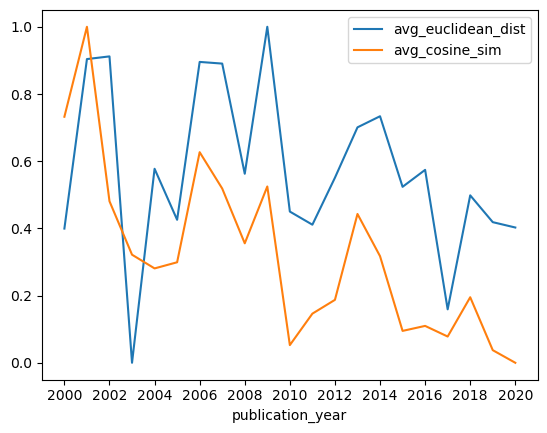

In [180]:
atomic_df.plot(x='publication_year', y=['avg_euclidean_dist','avg_cosine_sim'],
               kind='line')
plt.xticks(np.arange(2000, 2021, 2));

### Establish the pipeline

In [90]:
def ols_summary_plot(y, x, df):
    '''
    Analyzes the shift of musics features from 1950 to 2015
    Inputs:
        y: string, the name of dependent variable
        x: string, the name of independent variable
        df: pandas dataframe, data source of the analysis
    Outputs:
        OLS Regression Results and a scatter plot with a linear regression line
    '''

    mod = ols(formula='{} ~ {}'.format(y, x), data=df).fit()
    print(mod.summary())
    ax = df.plot(x=x, y=y, kind='scatter',
                title=f'Shift of {y} Over Publication Years', grid=True)
    plt.xlabel('Publication Year')
    plt.xticks(np.arange(2000, 2021, 2), rotation=45)
    fig = sm.graphics.abline_plot(model_results=mod, ax=ax)

In [91]:
def process_df(df):
    '''
    Process the dataframes and calculate the average euclidean distance
    and cosine similarity
    '''

    df['tokens'] = df["t25% of stemmed_tokens"].apply(lambda x: eval(x)[0])\
                                               .apply(lambda x: [i[0] for i in x])
    df['avg_euclidean_dist'] = df['tokens'].apply(avg_euclidean_dist).apply(lambda x: x.item())
    df['avg_cosine_sim'] = df['tokens'].apply(avg_cosine_sim).apply(lambda x: x.item())

    # minmax scale the data to 0 to 1
    df = minmax_scale(df, 'avg_euclidean_dist')
    df = minmax_scale(df, 'avg_cosine_sim')

    # save to local
    df.to_csv(f'data/glove_{df.name}.csv')

    # fit ols
    ols_summary_plot(y='avg_euclidean_dist', x='publication_year', df=df)
    ols_summary_plot(y='avg_cosine_sim', x='publication_year', df=df)
    
    return df

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.251
Date:                Sun, 05 Mar 2023   Prob (F-statistic):              0.277
Time:                        11:55:54   Log-Likelihood:               0.021136
No. Observations:                  21   AIC:                             3.958
Df Residuals:                      19   BIC:                             6.047
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           21.1625     18.408  

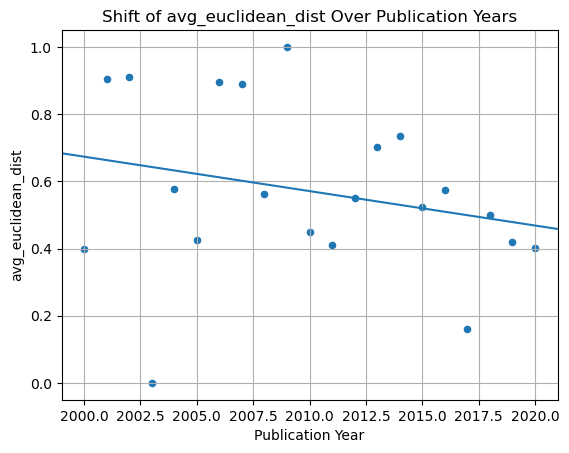

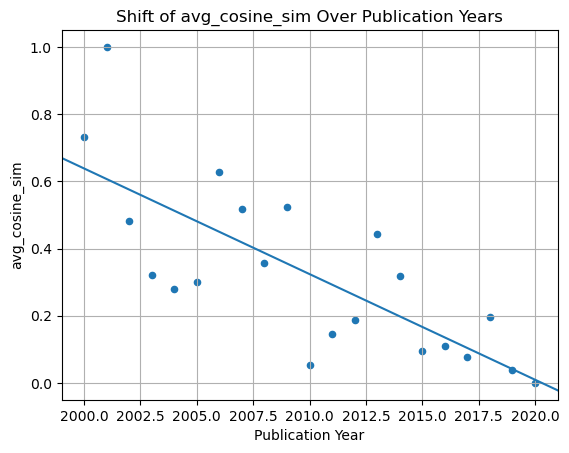

In [81]:
# cosine similarity is significant
atomic_df = process_df(atomic_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.076
Date:                Sun, 05 Mar 2023   Prob (F-statistic):              0.313
Time:                        11:56:17   Log-Likelihood:                 3.0649
No. Observations:                  21   AIC:                            -2.130
Df Residuals:                      19   BIC:                          -0.04084
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -15.9800     15.924  

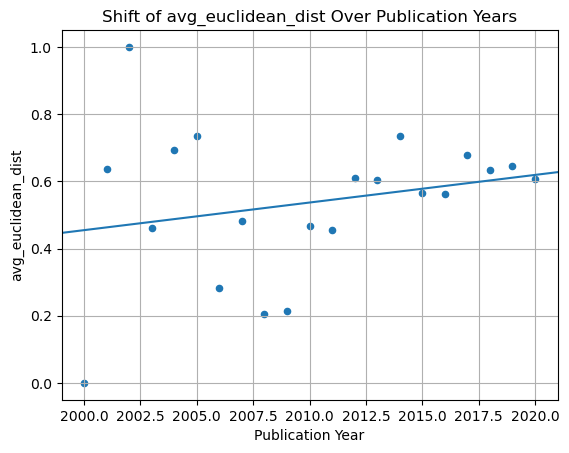

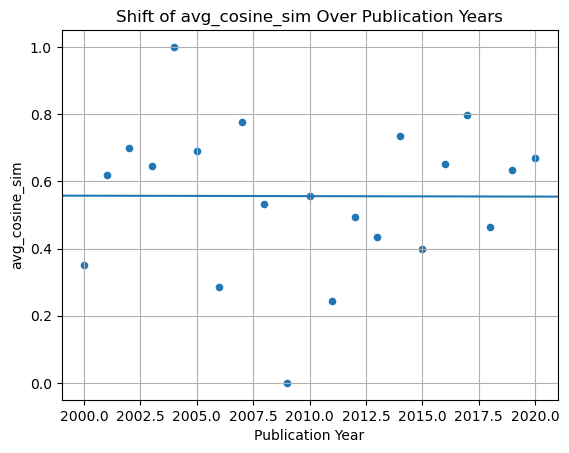

In [82]:
# both not significantå
geo_df = process_df(geo_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.052
Method:                 Least Squares   F-statistic:                  0.003266
Date:                Sun, 05 Mar 2023   Prob (F-statistic):              0.955
Time:                        11:57:35   Log-Likelihood:                -2.3915
No. Observations:                  21   AIC:                             8.783
Df Residuals:                      19   BIC:                             10.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7284     20.649  

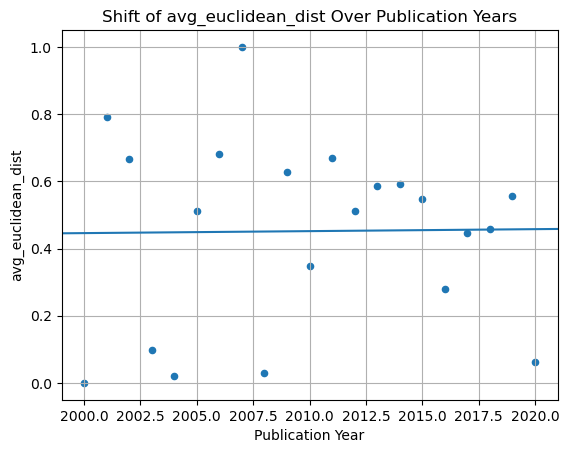

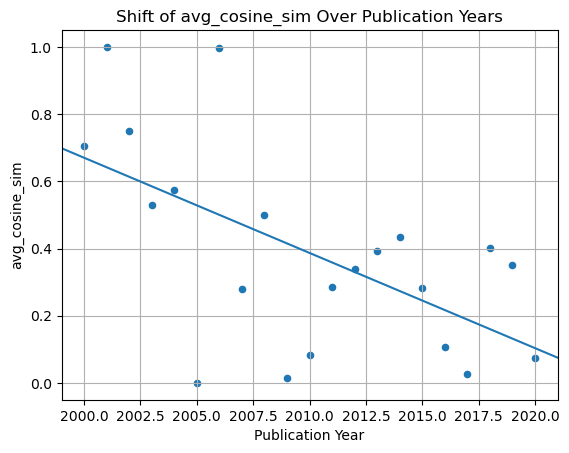

In [83]:
# cosine similarity significant
meteo_df = process_df(meteo_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     41.78
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           3.40e-06
Time:                        12:03:56   Log-Likelihood:                 7.6272
No. Observations:                  21   AIC:                            -11.25
Df Residuals:                      19   BIC:                            -9.165
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           83.3225     12.815  

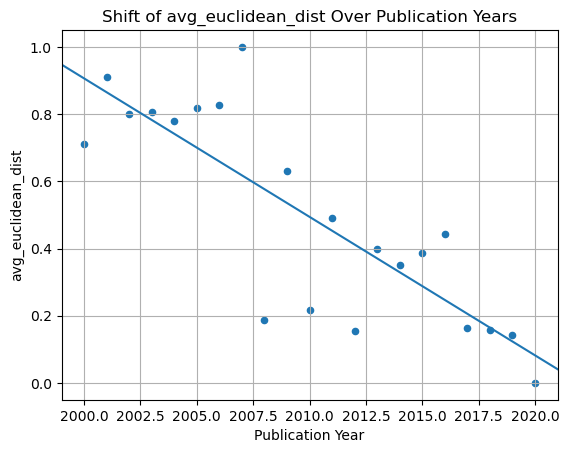

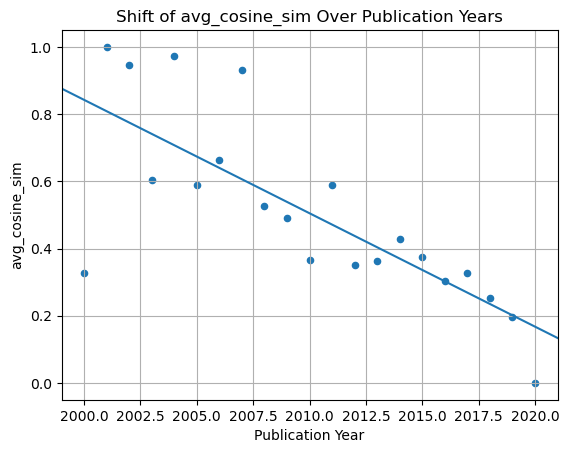

In [84]:
# both significant
ocean_df = process_df(ocean_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     4.745
Date:                Sun, 05 Mar 2023   Prob (F-statistic):             0.0422
Time:                        12:11:34   Log-Likelihood:               -0.13461
No. Observations:                  21   AIC:                             4.269
Df Residuals:                      19   BIC:                             6.358
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -39.8473     18.545  

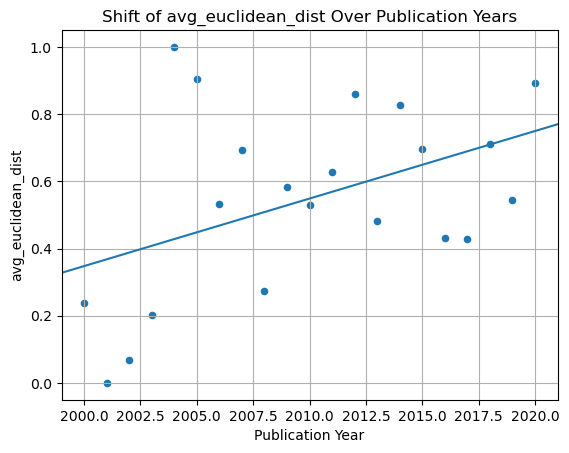

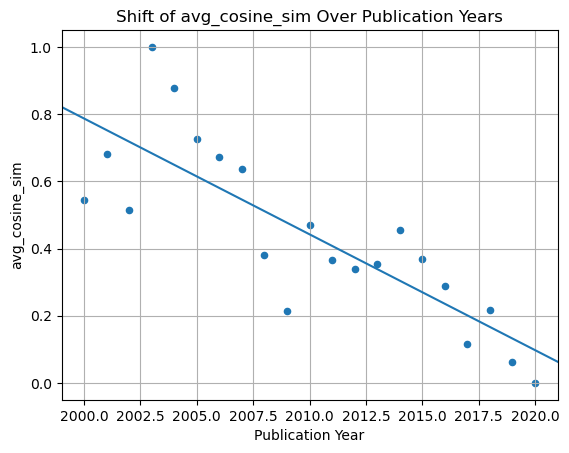

In [85]:
# cosine similarity
stats_df = process_df(stats_df)

                            OLS Regression Results                            
Dep. Variable:     avg_euclidean_dist   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     14.13
Date:                Sun, 05 Mar 2023   Prob (F-statistic):            0.00133
Time:                        12:14:33   Log-Likelihood:                 4.7653
No. Observations:                  21   AIC:                            -5.531
Df Residuals:                      19   BIC:                            -3.441
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           55.6455     14.686  

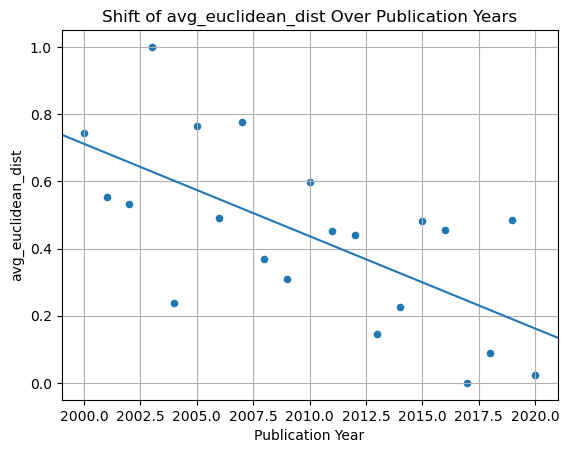

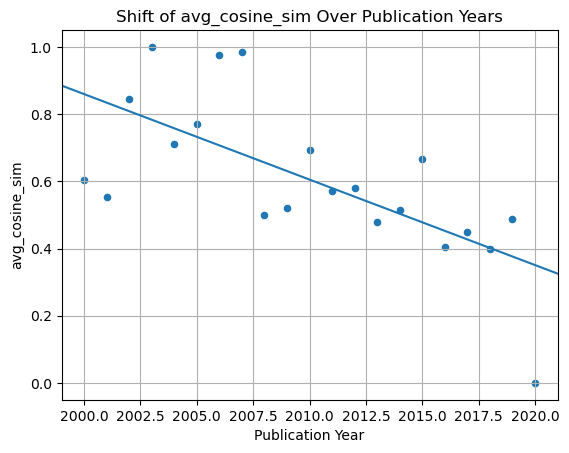

In [86]:
# both significant
thermo_df = process_df(thermo_df)

Finished analysis except for biophysics

### Merge dataframes

In [103]:
def select_cosine_sim(df):
    df_ = df.iloc[:, [0, -1]]
    df_ = df_.rename(columns={'avg_cosine_sim': df.name})

    return df_ 

In [104]:
atomic_cosim = select_cosine_sim(atomic_df)
geo_cosim = select_cosine_sim(geo_df)
meteo_cosim = select_cosine_sim(meteo_df)
ocean_cosim = select_cosine_sim(ocean_df)
stats_cosim = select_cosine_sim(stats_df)
thermo_cosim = select_cosine_sim(thermo_df)

In [109]:
cosim_df_lst = [atomic_cosim, geo_cosim, meteo_cosim, ocean_cosim, stats_cosim, thermo_cosim]

In [110]:
from functools import reduce
cosim_df = reduce(lambda left,right: pd.merge(left,right,on=['publication_year'],
                                            how='outer'), cosim_df_lst)

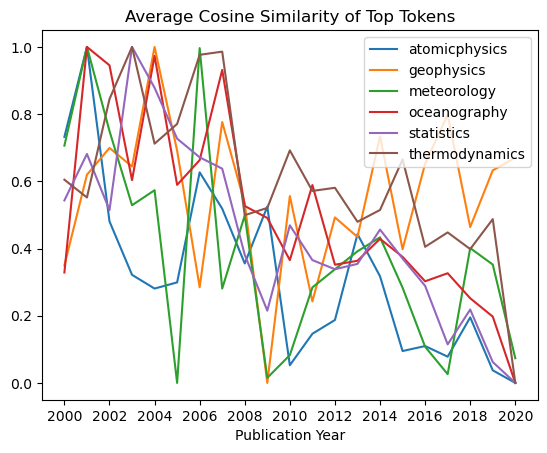

In [119]:
cosim_df.plot(x='publication_year', y=cosim_df.columns[1:].to_list(), 
              title='Average Cosine Similarity of Top Tokens',
              xlabel='Publication Year')
plt.xticks(np.arange(2000, 2021, 2));